In [0]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

In [0]:
np.random.seed(1)



---
Load data


---



---





In [0]:
def load_data():
  train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

  test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  
  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
  
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()



---

Flatten the dimensions

---



In [0]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

In [0]:
layers_dims = [12288, 20, 7, 5, 1]

In [0]:
# Activation functions----------------
def sigmoid(Z):
  A = 1/(1+np.exp(-Z))
  cache = Z
  
  return A, cache

def relu(Z):
  A = np.maximum(0,Z)
  
  assert(A.shape == Z.shape)
  
  cache = Z 
  return A, cache

In [0]:
# Activation Backward---------
def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True) # just converting dz to a correct object.
  
  # When z <= 0, set dz to 0 as well. 
  dZ[Z <= 0] = 0
  
  assert (dZ.shape == Z.shape)
  return dZ

def sigmoid_backward(dA, cache):
  Z = cache
  
  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s)
  
  assert (dZ.shape == Z.shape)
  return dZ

In [0]:
# initialize parameters of newral network
def initialize_parameters_deep(layer_dims):
  np.random.seed(1)
  parameters = {}
  L = len(layer_dims)            # number of layers in the network

  for l in range(1, L):
      parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
      parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
      
      assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
      assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

      
  return parameters  




---

**Forward propagation**

---



In [0]:
def linear_forward(A, W, b):
  Z = W.dot(A) + b
  
  assert(Z.shape == (W.shape[0], A.shape[1]))
  cache = (A, W, b)
  
  return Z, cache

In [0]:
def linear_activation_forward(A_prev, W, b, activation):
  
  if activation == "sigmoid":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = sigmoid(Z)
  
  elif activation == "relu":
      # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
      Z, linear_cache = linear_forward(A_prev, W, b)
      A, activation_cache = relu(Z)
  
  assert (A.shape == (W.shape[0], A_prev.shape[1]))
  cache = (linear_cache, activation_cache)

  return A, cache

In [0]:
def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters) // 2                  # number of layers in the neural network
  
  # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
  for l in range(1, L):
      A_prev = A 
      A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
      caches.append(cache)
  
  # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
  AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
  caches.append(cache)
  
  assert(AL.shape == (1,X.shape[1]))
          
  return AL, caches



---

***Compute Cost***



---



---




In [0]:
def compute_cost(AL, Y):
  m = Y.shape[1]

  # Compute loss from aL and y.
  cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
  
  cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (this turns [[17]] into 17).
  assert(cost.shape == ())
  
  return cost



---

***Backward Propagation***



---



---





In [0]:
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]

  dW = 1./m * np.dot(dZ,A_prev.T)
  db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T,dZ)
  
  assert (dA_prev.shape == A_prev.shape)
  assert (dW.shape == W.shape)
  assert (db.shape == b.shape)
  
  return dA_prev, dW, db

In [0]:
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  
  if activation == "relu":
      dZ = relu_backward(dA, activation_cache)
      dA_prev, dW, db = linear_backward(dZ, linear_cache)
      
  elif activation == "sigmoid":
      dZ = sigmoid_backward(dA, activation_cache)
      dA_prev, dW, db = linear_backward(dZ, linear_cache)
  
  return dA_prev, dW, db

In [0]:
# Back propagation
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads



---

**Update Parameters**



---



In [0]:
def update_parameters(parameters, grads, learning_rate):
  L = len(parameters) // 2 # number of layers in the neural network

  for l in range(L):
      parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
      parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
      
  return parameters



---
Prediction 


---



---




In [0]:
def predict(X, y, parameters):
  m = X.shape[1]
  n = len(parameters) // 2 # number of layers in the neural network
  p = np.zeros((1,m))
  
  # Forward propagation
  probas, caches = L_model_forward(X, parameters)

  
  # convert probas to 0/1 predictions
  for i in range(0, probas.shape[1]):
      if probas[0,i] > 0.5:
          p[0,i] = 1
      else:
          p[0,i] = 0
  
  #print results
  #print ("predictions: " + str(p))
  #print ("true labels: " + str(y))
  print("Accuracy: "  + str(np.sum((p == y)/m)))
      
  return p



---
Print mislabeled images


---



---




In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. 
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


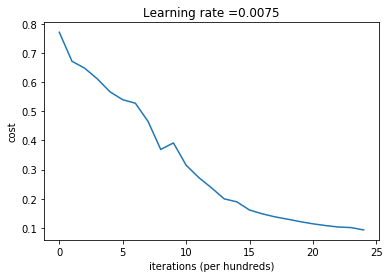

In [0]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [0]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [0]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8
